In [1]:
import torch
from tqdm.notebook import trange
from matplotlib import pyplot as plt
import numpy as np
import torchfire as tf
from torchfire.models import MLP, get_optimizer
import pandas as pd
from itertools import product
import os
import mup
from functools import partial

os.makedirs("algorithmic", exist_ok=True)

p = 51
seed = 0


rng = torch.Generator().manual_seed(seed)
X = torch.arange(51)
X = torch.tensor(list(product(X, X)))
y = X.sum(dim=1) % p

In [2]:
from torchfire.models import MLPEmbedding

model_fn = lambda w: tf.mup.make_mup(
    MLPEmbedding,
    MLPEmbedding.update_readout,
    {"vocab_size": p, "hidden_dims": [w, w], "output_dim": p},
    {"hidden_dims" : [2, 2]},
)

train_loader=torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X[:128], y[:128]), batch_size=128
 )

100%|██████████| 21/21 [00:05<00:00,  3.77it/s]


coord check plot saved to synthetic/μp_mlp_sgd_coord.png


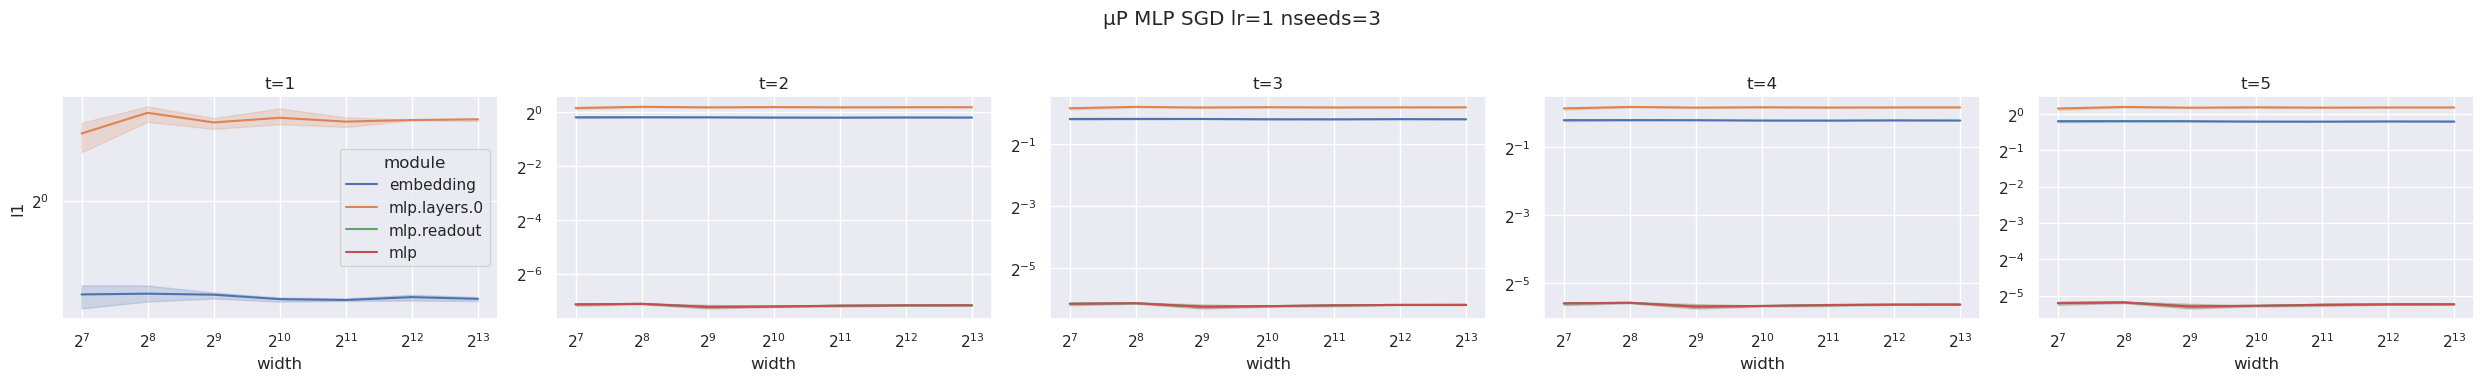

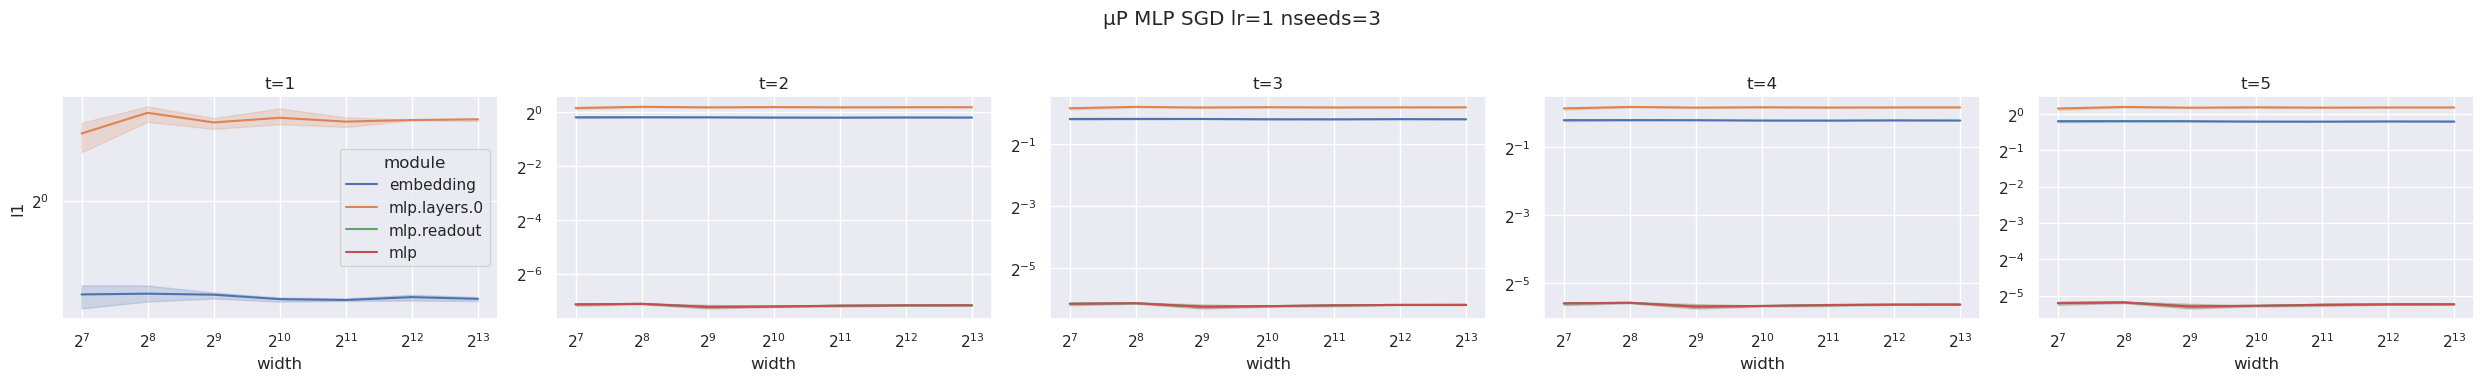

In [3]:
torch.manual_seed(seed)
tf.mup.coord_check(
    model_fn,
    mup=True,
    lr=1,
    train_loader=train_loader,
    lossfn='xent',
    nsteps=5,
    nseeds=3,
    legend=True,
    plotdir='synthetic')

In [5]:
widths = [32, 128, 512, 1024]
lrs = (np.array([0.8, 0.5, 1e-1, 2e-2, 1.5e-2, 1e-2, 5e-3])* 5).round(8)
seeds = range(3)
epochs = 2000

In [6]:
pbar = trange(len(widths) * len(seeds) * len(lrs))
use_mup = True

histories = []
for lr in lrs:
    for width in widths:
        for seed in seeds:
            row = {'lr': lr, 'width': width, 'seed': seed}
            pbar.update(1)
            torch.manual_seed(seed)
            model = model_fn(width) if use_mup else MLPEmbedding(p, [width, width], p)
            optimizer = get_optimizer(model, lr, use_mup=use_mup)
            flame_model = tf.Fire(model, optimizer, device='cuda', loss="xent")
            flame_model.fit(X, y, epochs=epochs, track_loss=10)
            row['losses'] = flame_model.history['loss']
            histories.append(row)
            acc = flame_model.get_acc(X, y)
            pbar.set_description(f'lr: {lr}, width: {width}, seed: {seed}, acc: {acc:.2f}')
pbar.close()

# export to csv
df = pd.DataFrame(histories)
df.to_csv(f'algorithmic/mup_{use_mup}.csv')

  0%|          | 0/84 [00:00<?, ?it/s]

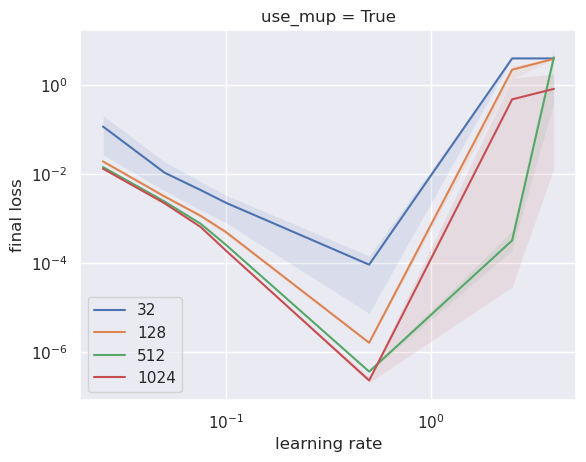

In [18]:
use_mup = True
df = pd.read_csv(f'algorithmic/mup_{use_mup}.csv', index_col=0)
df.losses = df.losses.apply(lambda x: eval(x))
# plot final loss for each width as a function of learning rate
df['last_loss'] = df.losses.apply(lambda x: x[-1])
# make shaded area for max and min and center is mean
max_ = df.groupby(['lr', 'width']).last_loss.max().unstack()
min_ = df.groupby(['lr', 'width']).last_loss.min().unstack()
mean_ = df.groupby(['lr', 'width']).last_loss.mean().unstack()

x_axis = mean_.index
for width in mean_.columns:
    plt.fill_between(x_axis, min_[width], max_[width], alpha=0.1)
    plt.plot(x_axis, mean_[width], label=width)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('learning rate')
plt.ylabel('final loss')
plt.title(f'use_mup = {use_mup}')
plt.savefig(f'algorithmic/final_loss_mup_{use_mup}.png')

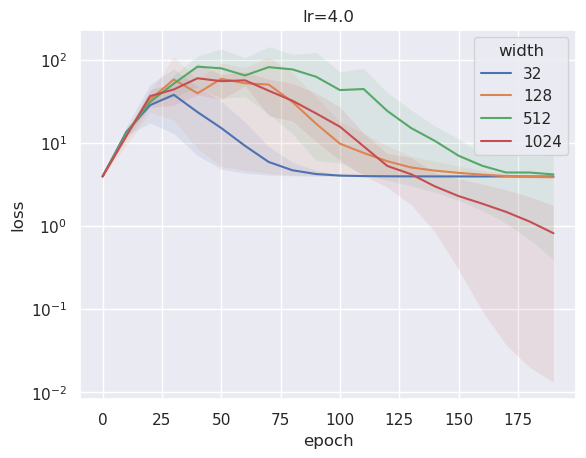

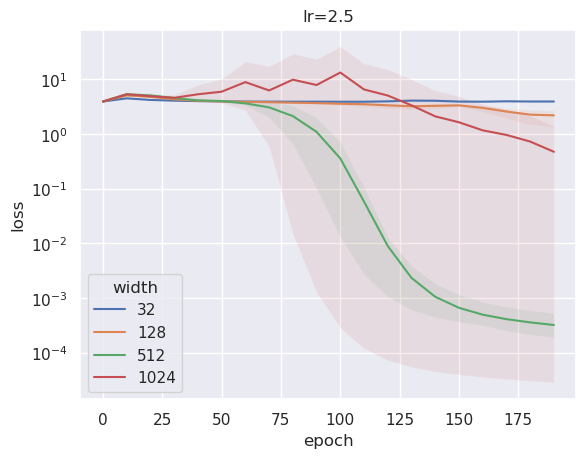

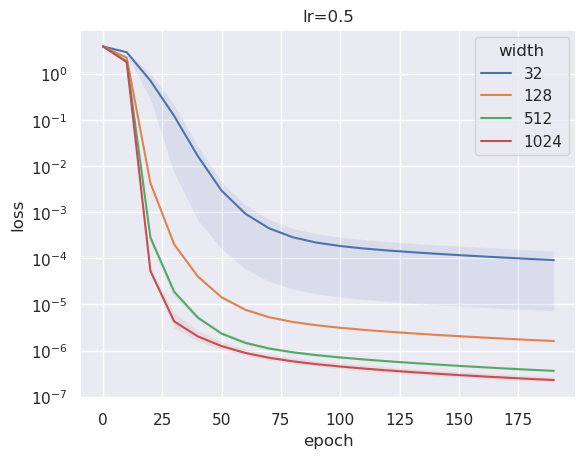

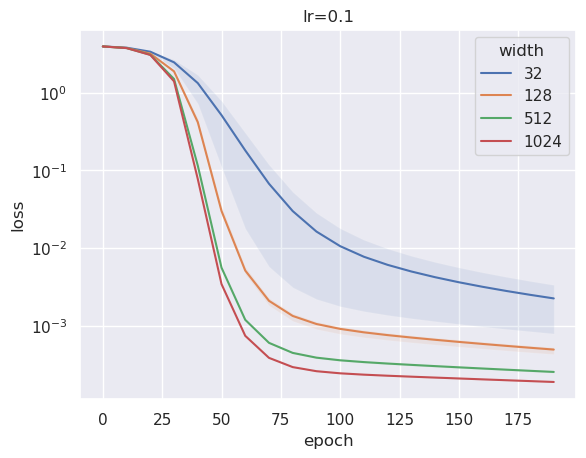

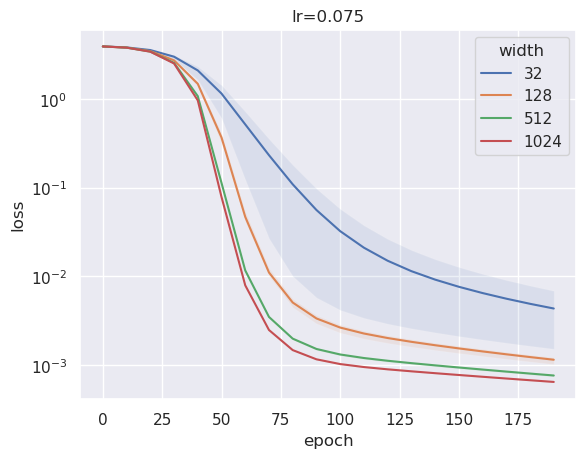

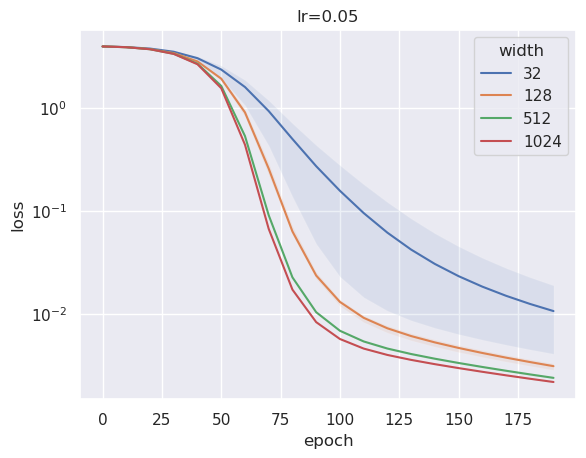

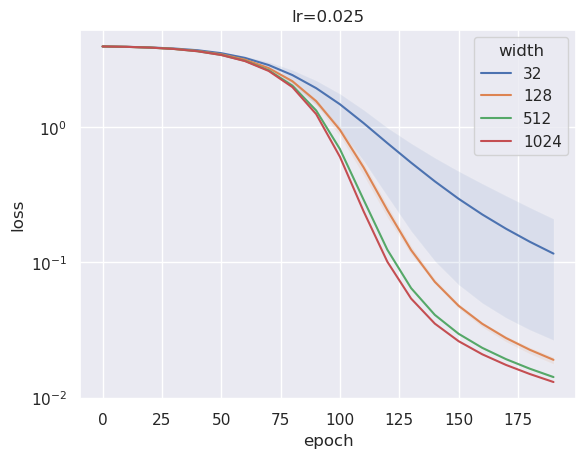

In [19]:
group = df.groupby(['lr', 'width']).losses

for lr in lrs.round(8):
    for c, width in enumerate(widths):
        losses = group.get_group((lr, width))
        losses = np.array(losses.tolist())
        mean_ = losses.mean(axis=0)
        max_ = losses.max(axis=0)
        min_ = losses.min(axis=0)
        x_axis = np.arange(len(mean_)) * 10
        plt.fill_between(x_axis, min_, max_, alpha=0.1)
        plt.plot(x_axis, mean_, label=width)
        
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.yscale('log')
    plt.title(f'lr={lr}')
    plt.legend(title="width")
    plt.savefig(f'algorithmic/loss_lr_{lr}_mup_{use_mup}.png')
    plt.show()


In [23]:
model.cpu()
(model(X).argmax(dim=1) == y).float().mean()

tensor(1.)